# Spotify Song Mood Recommendation Engine:
## Recommendation Engine
- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: July 2, 2022

In this notebook we will develop a content-based recommendation engine leveraging the Song Mood classification model to generate recommendations to the user. We will use the [Spotify Dataset 1921-2020, 600k+ Tracks from Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) as the candidate-track database.

The way to generate recommendation is to calculate the distance between each individual song to the user's favorite songs. To measure the distance, we used cosine similarity which should be capturing a more generalized music taste of the user and works better with higher dimension comparing to the other distance measurements.

### Table of Contents
1. [Candidate Dataset Cleaning and Wrangling](#Candidate-Dataset-Cleaning-and-Wrangling)
2. [Feature Engineering](#Feature-Engineering)
3. [Cosine Similarity Based Recommendation](#Cosine-Similarity-Based-Recommendation)
4. [Performance Analysis](#Performance-Analysis)

#### Import Packages and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
candidates_df = pd.read_csv('data/tracks.csv')
artists_df = pd.read_csv('data/artists.csv')
user_top_tracks_df = pd.read_csv('data/user_top_tracks.csv')

### Datasets Cleaning and Wrangling
We will start with our `candidates_df`.

In [3]:
candidates_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [4]:
candidates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

The candidate tracks dataset contains 586672 rows and 20 columns. There seem to be some tracks with name missing.

Let's fill the missing track names with `'unknown_track'`.

In [5]:
candidates_df['name'] = candidates_df['name'].fillna('unknown_track')

In [6]:
candidates_df.isnull().sum()

id                  0
name                0
popularity          0
duration_ms         0
explicit            0
artists             0
id_artists          0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

Now let's remove the duplicated tracks to speed up the run time.

In [7]:
print(f'There are {candidates_df.duplicated().sum()} duplicated rows')

There are 0 duplicated rows


The data has no duplicated rows. But as we mentioned in the classification notebook, Spotify sometimes assign different ids to the same song. So we would have to check it with `track name, artist` pair to find the duplicated tracks.

In [8]:
# Ref: https://github.com/madhavthaker/spotify-recommendation-system/blob/main/spotify-recommendation-engine.ipynb
candidates_df[candidates_df['name']=='Adore You']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
86217,5AnCLGg35ziFOloEnXK4uu,Adore You,71,278747,0,['Miley Cyrus'],['5YGY8feqx7naU7z4HrwZM6'],2013-10-04,0.583,0.655,0,-5.407,1,0.0315,0.1110,0.000004,0.113,0.201,119.759,4
91884,3jjujdWJ72nww5eGnfs2E7,Adore You,88,207133,0,['Harry Styles'],['6KImCVD70vtIoJWnq6nGn3'],2019-12-13,0.676,0.771,8,-3.675,1,0.0483,0.0237,0.000007,0.102,0.569,99.048,4
92524,1M4qEo4HE3PRaCOM7EXNJq,Adore You,74,207133,0,['Harry Styles'],['6KImCVD70vtIoJWnq6nGn3'],2019-12-06,0.676,0.771,8,-3.675,1,0.0483,0.0237,0.000007,0.102,0.569,99.048,4


In [9]:
# Using the same approach Madhav used to eliminate duplicate combinations
candidates_df['artists_song'] = candidates_df.apply(lambda row: row['artists'][0]+row['name'],axis = 1)
candidates_df = candidates_df.drop_duplicates('artists_song').reset_index().drop('index', axis=1)

In [10]:
586672 - candidates_df.shape[0], candidates_df.shape[0]

(140197, 446475)

We removed 140197 duplicated tracks with this method. Now we are left with 446475 unique tracks.

Since we read the data from a csv file, the cells storing list items would be imported as list-like strings.

In [11]:
candidates_df['id_artists'].iloc[0], type(candidates_df['id_artists'].iloc[0])

("['45tIt06XoI0Iio4LBEVpls']", str)

We would like to use genres as part of the recommendation factors. Since we need to retrieve the genres from the `artists_df`, we would have to convert the artist information into actual lists.

In [12]:
# Apply a lambda function to convert the genres to lists
def column_str2lst(df, column):
    return df[column].apply(
        lambda x: [i.strip("'[ ]'") for i in x.split(',')]
    )

In [13]:
candidates_df['artists'] = column_str2lst(candidates_df, 'artists')
candidates_df['id_artists'] = column_str2lst(candidates_df, 'id_artists')

In [14]:
# The list-like columns are successfully converted
type(candidates_df.iloc[0]['artists']), type(candidates_df.iloc[0]['id_artists'])

(list, list)

Let's take a look at the `artists_df`.

In [15]:
artists_df.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [16]:
artists_df['genres'].value_counts()

[]                                                                                                                   856500
['background piano']                                                                                                    307
['calming instrumental']                                                                                                256
['background music']                                                                                                    247
['russelater']                                                                                                          226
                                                                                                                      ...  
['christian hip hop', 'christian pop', 'christian trap', 'miami hip hop', 'rap cristiano']                                1
['edm', 'moldovan pop', 'pop dance', 'progressive house', 'progressive trance', 'trance', 'uplifting trance']             1
['comic'

Similar to above, we need to convert the `genres` into lists. Also, since we are only looking for genres, we can discard artists who does not have any genre associated with them.

In [17]:
artists_df = artists_df[artists_df['genres'] != '[]']
artists_df['genres'] = column_str2lst(artists_df, 'genres')

In [18]:
artists_df.shape[0]

305595

The `artists_df` now has 305595 rows. An naive approach of looking up the genres would be a nested lookup. Specifically, we will be looping through the `candidates_df` by rows, compare the `artist_id` to the `id` in `artists_df`, then set the `genre` value on matching cases. However, this algorithm has the time complexity of $O(M*N)$. Assuming each comparison takes 5 ms, and it takes about  we would need `465424*(305595/2)*5 ms` to make all the comparisons, which is about 11.27 years.

In addition, some tracks have multiple artists associated with them. We would want to attach the genres of all the artists associated with the track. This is hard to achieve even if we take the problem to SQL.

Also, the multiple artists might share the same genres, so we also need to only store the unique genres after combining theirs. 

Here is the method we used to tackle these problems:
1. we first used [Pandas's `explode` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html), which will transform each element of a list to a row, while replicating the other values. This way we can work with one artist at a time for the tracks.
2. Then we created a lookup table as the conjunction between `candidates_df` and `artists_df` and this way the time complexity should be much lower at $O(M+N)$.
3. We will convert the genres to list -> set -> list, then we should be left with the unique genres only.
4. Merge the genres back to `candidates_df`

In [19]:
# Rename candidates_df's id, name to track_id, track_name to avoid confusion
candidates_df.rename({'id':'track_id'}, axis=1, inplace=True)
candidates_df.rename({'name':'track_name'}, axis=1, inplace=True)

# Now we explode the `id_artists` and build the lookup table.
track_artist_lookup = candidates_df[['track_id', 'id_artists']].explode('id_artists')

# Combine with the artist data 
track_artist_lookup = track_artist_lookup.merge(artists_df, left_on='id_artists', right_on='id')

# Consolidate the exploded tracks columns back together
track_genres_df = track_artist_lookup.groupby('track_id')['genres'].apply(list).reset_index()

import itertools
# Remove the duplicated genres
track_genres_df['genres'] = track_genres_df['genres'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [20]:
# Now we have the mapping between track_id and genres
track_genres_df

,track_id,genres
0,0004Uy71ku11n3LMpuyf59,[polish rock]
1,000CSYu4rvd8cQ7JilfxhZ,"[country quebecois, rock quebecois]"
2,000DsoWJKHdaUmhgcnpr8j,[barnmusik]
3,000G1xMMuwxNHmwVsBdtj1,"[rock, new wave, power pop, permanent wave, ca..."
4,000KblXP5csWFFFsD6smOy,"[folklore argentino, folclore salteno, chamame]"
...,...,...
401502,7zzoxJbgjme3366mOp5UnH,"[pop, pop rap, dance pop]"
401503,7zzqq4eJe4zKpYCHckNi1K,"[bossa nova, nova mpb, mpb]"
401504,7zztLmdxNYrjTQ4XqUK8cp,"[estonian pop, estonian rock]"
401505,7zztk8Ecg9qDRLX3XNfSyq,"[europop, swedish pop, classic swedish pop]"


In [21]:
# Finally we can append the genres to the original candidates df
candidates_df = candidates_df.merge(track_genres_df, on='track_id')
candidates_df

,track_id,track_name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_song,genres
0,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,[Vivo para Quererte - Remasterizado,"[vintage tango, tango]"
1,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,[El Prisionero - Remasterizado,"[vintage tango, tango]"
2,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,...,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,[Lady of the Evening,"[swing, big band, lounge, adult standards, eas..."
3,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.227,0.2610,...,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4,[Ave Maria,"[swing, big band, lounge, adult standards, eas..."
4,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,[Mistinguett],[4AxgXfD7ISvJSTObqm4aIE],1922,0.563,0.1840,...,1,0.0512,0.993,0.000016,0.3250,0.6540,133.088,3,[La Java,[vintage chanson]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401502,0SjsIzJkZfDU7wlcdklEFR,John Brown's Song,66,185250,0,[Gregory Oberle],[4MxqhahGRT4BPz1PilXGeu],2020-03-20,0.562,0.0331,...,1,0.1030,0.996,0.961000,0.1110,0.3860,63.696,3,[John Brown's Song,[instrumental lullaby]
401503,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,[阿YueYue],[1QLBXKM5GCpyQQSVMNZqrZ],2020-09-26,0.560,0.5180,...,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,[云与海,[chinese viral pop]
401504,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,[ROLE MODEL],[1dy5WNgIKQU6ezkpZs4y8z],2020-10-21,0.765,0.6630,...,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,[blind,"[alt z, bedroom pop, indie pop, indie cafe pop..."
401505,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,[FINNEAS],[37M5pPGs6V1fchFJSgCguX],2020-09-02,0.535,0.3140,...,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,[What They'll Say About Us,"[post-teen pop, la indie, alt z, indie pop, el..."


Now let's take a look at our user's top tracks.

In [22]:
user_top_tracks_df.head()

,Unnamed: 0,track_name,track_id,artist_name,artist_id,album_name,album_id,popularity,mood,time_range,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,genres
0,0,My Ordinary Life,6tMdpUXfT70TD6Eh3XfB1p,The Living Tombstone,0I6yADrmeyvw66g7yjkqIF,My Ordinary Life,4AmFZET7RGujQAhG80kjwu,80,NaN,short_term,...,0.0420,0.00533,0.338,0.2170,0.598,176.005,audio_features,230895,4,['fnaf']
1,1,My Ordinary Life,6tMdpUXfT70TD6Eh3XfB1p,The Living Tombstone,0I6yADrmeyvw66g7yjkqIF,My Ordinary Life,4AmFZET7RGujQAhG80kjwu,80,NaN,medium_term,...,0.0420,0.00533,0.338,0.2170,0.598,176.005,audio_features,230895,4,['fnaf']
2,2,april,6nFf2vBzne2lG8TEDecEtJ,caaaaseyyyy,5H3d73o1RCWNsGE9SrT57c,april,3Et7sVGjEF2FIewwDtosOg,30,NaN,short_term,...,0.0254,0.75600,0.464,0.0802,0.656,95.009,audio_features,223895,4,[]
3,3,april,6nFf2vBzne2lG8TEDecEtJ,caaaaseyyyy,5H3d73o1RCWNsGE9SrT57c,april,3Et7sVGjEF2FIewwDtosOg,30,NaN,medium_term,...,0.0254,0.75600,0.464,0.0802,0.656,95.009,audio_features,223895,4,[]
4,4,We Not Humping - Remix,4ue41gFbAjoU0P1EberJWm,Monaleo,2sflbTtCirog5VxD6jPAfb,We Not Humping (Remix),1V9eCkZxExdad79zHEE6Dk,74,NaN,short_term,...,0.2690,0.03440,0.000,0.0920,0.810,120.008,audio_features,143325,4,['viral rap']


In [23]:
user_top_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        80 non-null     int64  
 1   track_name        80 non-null     object 
 2   track_id          80 non-null     object 
 3   artist_name       80 non-null     object 
 4   artist_id         80 non-null     object 
 5   album_name        80 non-null     object 
 6   album_id          80 non-null     object 
 7   popularity        80 non-null     int64  
 8   mood              0 non-null      float64
 9   time_range        80 non-null     object 
 10  danceability      80 non-null     float64
 11  energy            80 non-null     float64
 12  key               80 non-null     int64  
 13  loudness          80 non-null     float64
 14  mode              80 non-null     int64  
 15  speechiness       80 non-null     float64
 16  acousticness      80 non-null     float64
 17 

In [24]:
# drop the redundant index
user_top_tracks_df = user_top_tracks_df.drop('Unnamed: 0', axis=1)

Now let's move on to feature engineering where we prepare the features needed to make recommendations.

### Feature Engineering

In [25]:
user_top_tracks_df['time_range'].value_counts()

long_term      50
medium_term    20
short_term     10
Name: time_range, dtype: int64

We have 80 tracks representing the user's music taste. We used the top 50 tracks from their long term preference, which is in the past several years, 20 from the medium term, which is in the past 6 month, and 10 from the short term, which is in the past 4 weeks. Combining these tracks together, we can see there might some tracks that appeared in more than one of these time ranges. We can use such frequency as the preference weight and make them have larger impacts when making recommendations.

We also see that the `mood` column is waiting to be filled.

Let's make these features for our datasets!

We will start with `mood` which needs to be added to all the tracks in our datasets. Let's import our classification model.

In [26]:
from joblib import load
mood_classifier = load('./models/mood_classification_model.joblib')
moods = ['Happy', 'Sad', 'Energetic', 'Calm']

We need to make the classification from the features that we trained the model on.

In [27]:
mood_classification_features = [
    'popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'duration_ms', 'time_signature'
]

In [28]:
# for candidates df
candidates_mood_classfication_df = candidates_df[mood_classification_features]
candidates_df['mood'] = mood_classifier.predict(candidates_mood_classfication_df)
candidates_df['mood'] = candidates_df['mood'].apply(lambda x: moods[x])
candidates_df

,track_id,track_name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_song,genres,mood
0,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,...,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,[Vivo para Quererte - Remasterizado,"[vintage tango, tango]",Energetic
1,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,...,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,[El Prisionero - Remasterizado,"[vintage tango, tango]",Calm
2,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,...,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,[Lady of the Evening,"[swing, big band, lounge, adult standards, eas...",Energetic
3,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.227,0.2610,...,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4,[Ave Maria,"[swing, big band, lounge, adult standards, eas...",Energetic
4,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,[Mistinguett],[4AxgXfD7ISvJSTObqm4aIE],1922,0.563,0.1840,...,0.0512,0.993,0.000016,0.3250,0.6540,133.088,3,[La Java,[vintage chanson],Energetic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401502,0SjsIzJkZfDU7wlcdklEFR,John Brown's Song,66,185250,0,[Gregory Oberle],[4MxqhahGRT4BPz1PilXGeu],2020-03-20,0.562,0.0331,...,0.1030,0.996,0.961000,0.1110,0.3860,63.696,3,[John Brown's Song,[instrumental lullaby],Calm
401503,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,[阿YueYue],[1QLBXKM5GCpyQQSVMNZqrZ],2020-09-26,0.560,0.5180,...,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,[云与海,[chinese viral pop],Sad
401504,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,[ROLE MODEL],[1dy5WNgIKQU6ezkpZs4y8z],2020-10-21,0.765,0.6630,...,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,[blind,"[alt z, bedroom pop, indie pop, indie cafe pop...",Happy
401505,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,[FINNEAS],[37M5pPGs6V1fchFJSgCguX],2020-09-02,0.535,0.3140,...,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,[What They'll Say About Us,"[post-teen pop, la indie, alt z, indie pop, el...",Sad


In [29]:
# for user top tracks
user_mood_classfication_df = user_top_tracks_df[mood_classification_features]
user_top_tracks_df['mood'] = mood_classifier.predict(user_mood_classfication_df)
user_top_tracks_df['mood'] = user_top_tracks_df['mood'].apply(lambda x: moods[x])
user_top_tracks_df[['track_name', 'mood']].head()

,track_name,mood
0,My Ordinary Life,Energetic
1,My Ordinary Life,Energetic
2,april,Energetic
3,april,Energetic
4,We Not Humping - Remix,Happy


Now let's move on to making the `preference_weight` to refine our knowledge about the user's preference.

We will assign a exponential weight calculated as $e^{freq}$ to the this preference based on the assumption that if a user had been playing a track consistently throughout different time ranges, it shows that they have a strong preference to the track.

In [30]:
# Generate a lookup table between track_name and weight
preference_weight_df = user_top_tracks_df[['track_name', 'time_range']]\
                            .groupby('track_name').count()\
                            .sort_values('time_range', ascending=False)\
                            .reset_index()

# Transform the weights to a exponential scale
preference_weight_df['time_range'] = preference_weight_df['time_range'].apply(lambda x: np.exp(x))

# Rename the column to weight
preference_weight_df = preference_weight_df.rename({'time_range': 'preference_weight'}, axis=1)

# Merge back to the original user top tracks df
user_top_tracks_df = preference_weight_df.merge(user_top_tracks_df.drop('time_range', axis=1)\
                           .drop_duplicates(),
                           on='track_name')

In [31]:
user_top_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_name         74 non-null     object 
 1   preference_weight  74 non-null     float64
 2   track_id           74 non-null     object 
 3   artist_name        74 non-null     object 
 4   artist_id          74 non-null     object 
 5   album_name         74 non-null     object 
 6   album_id           74 non-null     object 
 7   popularity         74 non-null     int64  
 8   mood               74 non-null     object 
 9   danceability       74 non-null     float64
 10  energy             74 non-null     float64
 11  key                74 non-null     int64  
 12  loudness           74 non-null     float64
 13  mode               74 non-null     int64  
 14  speechiness        74 non-null     float64
 15  acousticness       74 non-null     float64
 16  instrumentalness   74 non-nu

Now let's pick the features that we want to use when making a recommendation. From our classification process, we can see that `mood` is essentially a generalization of features that are relevant. So we should be able to discard all the audio features since they are either already generalized by the `mood` or statistically not significant. We still want to use the genres since they are also great abstractions of the music.

Therefore, for the scope of this project, we will only use `mood` and `genres`.

We have all the information needed to compare the candidate tracks to the user items. Currently, the `genres` and `mood` information are stored as categorical variables. We would need to transform them into numerical dummy variables so the machine could actually use them. We will use `LabelBinarizer` from SciKit-Learn to map the `moods` into dummy variables, and for `genres`, we will use a Tf-IDF transformer to convert them into vectors with weights assigned based on their frequency in the dataset.

In [32]:
# similar to the candidates df, we need to convert the genres to lists to use them
user_top_tracks_df['genres'] = column_str2lst(user_top_tracks_df, 'genres')

In [33]:
from sklearn.preprocessing import LabelBinarizer

def generate_mood_labels(df, mood):
    '''Generate a mood matrixs from the mood column in the dataframe
    
    Args:
        df (DataFrame): the dataframe we want to generate the matrix for
        mood (str): the name of the mood column
    '''
    lb = LabelBinarizer(sparse_output=False)
    mood_matrix = lb.fit_transform(df[mood])
    return lb, mood_matrix
generate_mood_labels(candidates_df, 'mood')[1].shape

(401507, 4)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_genre_vectors(df, genres, max_features=None, tfidf=None):
    '''Generate a genre matrixs from the genre column in the dataframe
    
    Args:
        df (DataFrame): the dataframe we want to generate the matrix for
        genres (str): the name of the genres column
    '''
    if not tfidf:
        tfidf = TfidfVectorizer(max_features=max_features)
        tfidf.fit(df[genres].apply(lambda x: ' '.join(x)))
    genres_vectors = tfidf.transform(df[genres].apply(lambda x: ' '.join(x))).todense()
    return tfidf, genres_vectors
generate_genre_vectors(candidates_df, 'genres')[1].shape

(401507, 2333)

Both of the mood matrix and genres vectors has the same number of rows. Combining them together, we will get a matrix of shape (401507,2337) in which each row represent a track.

In [35]:
def generate_data_matrixes(candidates_df, user_top_tracks_df, max_features=None):
    '''Generate the candidate data matrixes and user vector
    '''
    (lb, candidates_mood_matrix) = generate_mood_labels(candidates_df, 'mood')
    (tfidf, candidates_genres_vectors) = generate_genre_vectors(candidates_df, 'genres', max_features)
    candidates = np.hstack((candidates_mood_matrix, candidates_genres_vectors))

    (lb_user, user_mood_matrix) = generate_mood_labels(user_top_tracks_df, 'mood')
    (tfidf_user, user_genres_vectors) = generate_genre_vectors(user_top_tracks_df, 'genres', tfidf=tfidf)
    user_top_tracks = np.hstack((user_mood_matrix, user_genres_vectors))
    
    return candidates, user_top_tracks, lb_user, tfidf_user

(candidates, user_top_tracks, lb_user, tfidf_user) = generate_data_matrixes(candidates_df, user_top_tracks_df)

Let's try to build our recommendation system with consine similarity!

### Cosine Similarity Based Recommendation

For the cosine similarity approach, we need to generate a user vector and compare it with the individual tracks. The closer the angle between user vector and the track vector, the more similar they will be: 
<img src='https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/assets/2b4a7a82-ad4c-4b2a-b808-e423a334de6f.png'>

We will generate the user vector by multiplying the weights assigned to the tracks and `user top tracks` data matrix . In our case, the data matrix has the shape of $74*2337$, and the weights has the shape of $1*74$. The multiplication $W_{user}*M_{user}$ should give generating a weighted data matrix of shape $(1, 74) * (74, 2337) = (1, 2337)$, which is a vector with length of 2337.

Cosine similarity only compare the direction of the vector so it works well even for high dimensional data.

Let's generate the user vector!

In [36]:
weights = user_top_tracks_df['preference_weight'].to_numpy()
user_vector = weights * user_top_tracks
user_vector.shape

(1, 2337)

We have the user vector generated. Now we can compare it with all the candidates.

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(candidates, user_vector)

In [38]:
candidates_sim_df = candidates_df.copy()
candidates_sim_df['similarities'] = similarities
results_df_sim = candidates_sim_df.sort_values('similarities', ascending=False).head(40)
results_df_sim

,track_id,track_name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_song,genres,mood,similarities
66027,11zf7m4vw9Ze7cer9Nyhk1,Pleaser,72,187896,0,[Wallows],[0NIPkIjTV8mB795yEIiPYL],2017-04-12,0.497,0.914,...,0.126000,0.000020,0.2740,0.385,148.893,4,[Pleaser,"[rock, pop, indie pop, modern rock]",Happy,0.637716
57367,1pHP4JeQV9wDx87D6qH9hD,Here It Goes Again,67,179813,0,[OK Go],[3hozsZ9hqNq7CoBGYNlFTz],2005-01-01,0.537,0.882,...,0.000342,0.000091,0.1200,0.810,145.729,4,[Here It Goes Again,"[dance-punk, modern alternative rock, rock, mo...",Happy,0.622833
60154,2laAFvo3q3GIcXX7Ql8OeD,Like or Like Like,64,158653,0,[Miniature Tigers],[7xWU2A2lw1xf4zTjKhkrGK],2009-09-22,0.752,0.533,...,0.034500,0.000004,0.0971,0.838,96.077,4,[Like or Like Like,"[indie rock, indie pop, modern rock]",Happy,0.617885
59750,3Gp3KGChMmdv5v8ahwOCCR,Like Or Like Like,59,156653,0,[Miniature Tigers],[7xWU2A2lw1xf4zTjKhkrGK],2008-09-16,0.750,0.528,...,0.029700,0.000012,0.0957,0.864,96.094,4,[Like Or Like Like,"[indie rock, indie pop, modern rock]",Happy,0.617885
67045,57RA3JGafJm5zRtKJiKPIm,Are You Bored Yet? (feat. Clairo),85,178000,0,"[Wallows, Clairo]","[0NIPkIjTV8mB795yEIiPYL, 3l0CmX0FuQjFxr8SK7Vqag]",2019-03-22,0.682,0.683,...,0.156000,0.000023,0.2730,0.640,120.023,4,[Are You Bored Yet? (feat. Clairo),"[rock, modern rock, bedroom pop, indie pop, pop]",Happy,0.616099
171376,6dtPJwNdLuyVGPWyHOI6GP,It's Only Sex,60,283000,1,[Car Seat Headrest],[5PbpKlxQE0Ktl5lcNABoFf],2013-10-27,0.589,0.519,...,0.368000,0.457000,0.1190,0.482,119.981,4,[It's Only Sex,"[indie rock, alternative rock, indie pop, mode...",Sad,0.614646
63237,4kbj5MwxO1bq9wjT5g9HaA,Shut Up and Dance,82,199080,0,[WALK THE MOON],[6DIS6PRrLS3wbnZsf7vYic],2014-12-02,0.578,0.866,...,0.007010,0.000000,0.2570,0.619,128.038,4,[Shut Up and Dance,"[modern alternative rock, rock, modern rock, d...",Happy,0.612348
62167,3e0yTP5trHBBVvV32jwXqF,Anna Sun,66,321280,0,[WALK THE MOON],[6DIS6PRrLS3wbnZsf7vYic],2012-06-19,0.472,0.844,...,0.001730,0.000000,0.2400,0.340,140.034,4,[Anna Sun,"[modern alternative rock, rock, modern rock, d...",Happy,0.612348
82151,3Xzog9enTvbsc0G7G9M58D,Shut Up and Dance - Live Acoustic - 2015,62,193987,0,[WALK THE MOON],[6DIS6PRrLS3wbnZsf7vYic],2015-09-04,0.820,0.615,...,0.151000,0.000000,0.2040,0.768,129.874,4,[Shut Up and Dance - Live Acoustic - 2015,"[modern alternative rock, rock, modern rock, d...",Happy,0.612348
66067,0M1A9wInEHilyWkh4I8tWo,Lost In The Wild,71,235960,0,[WALK THE MOON],[6DIS6PRrLS3wbnZsf7vYic],2017-11-10,0.483,0.770,...,0.007000,0.000000,0.1820,0.386,132.992,4,[Lost In The Wild,"[modern alternative rock, rock, modern rock, d...",Happy,0.612348


We successfully acquired some results! But if we look carefully, we would see that the mood did not seem to have much impact as the majority of the recommendations are `Happy` tracks.

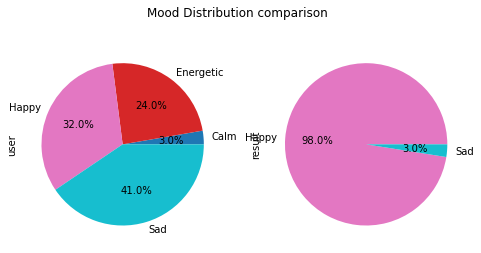

In [39]:
def compare_mood_distribution(actual, result):
    mood_distribution = pd.DataFrame([
            actual.groupby('mood')['track_name'].count(),
            result.groupby('mood')['track_name'].count()
        ],
        index=['user', 'result']
    ).transpose()
    
    # 2 pie plots to compare
    # autopct removed 0 pct labels referring
    # https://stackoverflow.com/questions/50449628/how-to-remove-0-from-pie-chart
    mood_distribution.plot(figsize=(8,4), kind='pie', subplots=True, legend=False,
                           autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',
                           title='Mood Distribution comparison', cmap='tab10')
    plt.show()
    
compare_mood_distribution(user_top_tracks_df, results_df_sim)

There are a couple of theories that could explain this:
- The user vector could be heavily weighted on `Happy` tracks which causes the similarity to be heavily shifted towards `Happy`.
- There are way too many features from `genres` so the `mood` is not as significant

Let's take a look at the `user_vector` and experiment with the `max_features` of `genres` to see if there is anything that we can find!

In [40]:
user_vector[0, :4], lb_user.classes_

(matrix([[ 5.43656366, 58.27062145, 83.92186096, 81.54845485]]),
 array(['Calm', 'Energetic', 'Happy', 'Sad'], dtype='<U9'))

`Happy` is the most preferred mood of the user but `Sad` is very close to it as well.

Now let's look at how does the distribution of the `mood` change as we change the number of genres to when making recommendations.

In [41]:
def make_recommendations(candidates_df, user_top_tracks_df, max_genres=50):
    (candidates, user_top_tracks, lb_user, tfidf_user) = generate_data_matrixes(
        candidates_df, user_top_tracks_df, max_genres)
    print(candidates.shape, user_top_tracks.shape)
    weights = user_top_tracks_df['preference_weight'].to_numpy()
    user_vector = weights * user_top_tracks

    print(user_vector.shape)
    similarities = cosine_similarity(candidates, user_vector)

    candidates_sim_df = candidates_df.copy()
    candidates_sim_df['similarities'] = similarities
    results_df_sim = candidates_sim_df.sort_values('similarities', ascending=False).head(40)

    print(f'Comparison of mood distribution with max genres of {max_genres}:')
    compare_mood_distribution(user_top_tracks_df, results_df_sim)
    
    return user_vector, results_df_sim

(401507, 5) (74, 5)
(1, 5)
Comparison of mood distribution with max genres of 1:


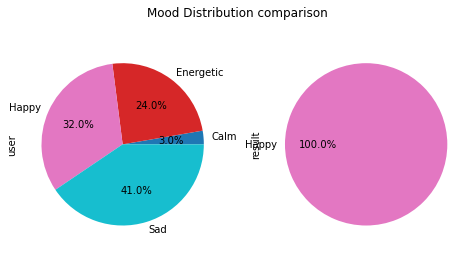

(401507, 54) (74, 54)
(1, 54)
Comparison of mood distribution with max genres of 50:


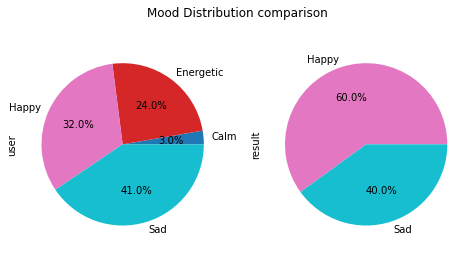

(401507, 204) (74, 204)
(1, 204)
Comparison of mood distribution with max genres of 200:


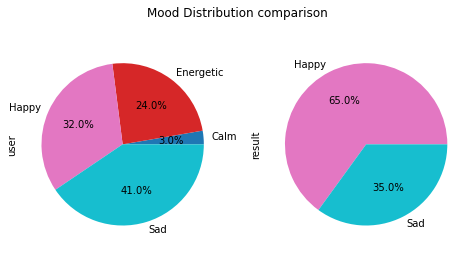

(401507, 1004) (74, 1004)
(1, 1004)
Comparison of mood distribution with max genres of 1000:


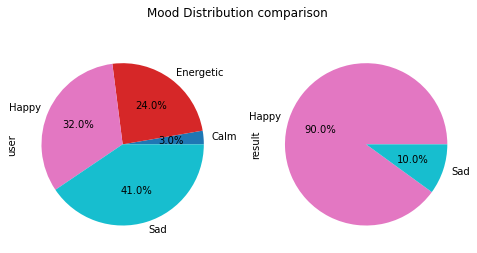

In [42]:
max_genres_trials = [1, 50, 200, 1000]
user_vectors = []
recommendations = []

for max_genres in max_genres_trials:
    (user_vector, results_df_sim) = make_recommendations(
        candidates_df, user_top_tracks_df, max_genres)
    
    # Save the user vectors and recommendations
    user_vectors.append(user_vector)
    recommendations.append(results_df_sim)

We see some very interesting results:

- The recommendations seem to be only consisted of `Happy` and `Sad` tracks no matter how many features we choose. However, The distribution varies drastically. 
- When the similarity is computed purely based on `mood` (only using 1 genre), we get 100% `Happy` tracks as the recommendation.
- As we begin to include more genres, we start to see more `Sad` tracks being included in the recommendation
- As the number of genres increase further, the distribution starts to gradually shift towards `Happy` again. Eventually as we consider all the existing genres in the candidate dataset, we get 98% `Happy` songs.

After doing A LOT of research, we were able to come up with the following explanation:
- If we only use the `mood` as the factor for calculating similarity (at least close to), the `Happy` tracks dominate since the user has the highest preference in the `Happy` track.
- As the number of genres start to increase, TF-IDF starts to bring in the rarer genres that actually can be found in the `user_top_tracks` with high scores. This results in higher impact from the `genre` part and that's why we start to see songs that are not `Happy` being recommended. However, since all the `mood` other than `Sad` are much lower in the user's preference, the only other `mood` that would be recommended is `Sad`.
- As the genres increase to a much larger scale. The performance of cosine similarity starts to drop due to the curse of dimensionality. The similarity between the data points slowly converges to 0 as more features are introduced. So the mood distribution should appear to be even as the feature number approaches infinity. We see a gradual increase in `Happy` but it is probably just the similarity randomly converging in the transition to even.

In [43]:
# empty feature ratio when we use 50 genres
(user_vectors[1][0, :] == 0).sum() / user_vectors[1][0, :].shape[1]

0.42592592592592593

In [44]:
# empty feature ratio when we use 1000 genres
(user_vector[0, :] == 0).sum() / user_vector[0, :].shape[1]

0.9223107569721115

In [45]:
# list of unique genres in the user top tracks
user_top_tracks_df.explode('genres')['genres'].value_counts()

rock                  15
pop                    9
modern rock            9
dream pop              7
permanent wave         7
                      ..
glitchcore             1
chinese indie rock     1
chinese minyao         1
baltimore indie        1
taiwan punk            1
Name: genres, Length: 103, dtype: int64

In [46]:
recommendations[3]

,track_id,track_name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_song,genres,mood,similarities
67045,57RA3JGafJm5zRtKJiKPIm,Are You Bored Yet? (feat. Clairo),85,178000,0,"[Wallows, Clairo]","[0NIPkIjTV8mB795yEIiPYL, 3l0CmX0FuQjFxr8SK7Vqag]",2019-03-22,0.682,0.683,...,0.156000,0.000023,0.2730,0.640,120.023,4,[Are You Bored Yet? (feat. Clairo),"[rock, modern rock, bedroom pop, indie pop, pop]",Happy,0.671242
66027,11zf7m4vw9Ze7cer9Nyhk1,Pleaser,72,187896,0,[Wallows],[0NIPkIjTV8mB795yEIiPYL],2017-04-12,0.497,0.914,...,0.126000,0.000020,0.2740,0.385,148.893,4,[Pleaser,"[rock, pop, indie pop, modern rock]",Happy,0.664162
211086,4Qmm1kIX3RO1DKdsYQbLK0,Crooked Teeth,48,203733,0,[Death Cab for Cutie],[0YrtvWJMgSdVrk3SfNjTbx],2005-08-29,0.579,0.662,...,0.000625,0.000004,0.1170,0.574,102.951,4,[Crooked Teeth,"[modern rock, indie rock, washington indie, in...",Happy,0.653262
321817,2bD1AW4yqiCurGCva6r88a,You Are a Tourist,53,286653,0,[Death Cab for Cutie],[0YrtvWJMgSdVrk3SfNjTbx],2011-05-27,0.569,0.872,...,0.000254,0.144000,0.2830,0.661,95.160,4,[You Are a Tourist,"[modern rock, indie rock, washington indie, in...",Happy,0.653262
92775,77vYwoC7e3pVoPq8BA9CuL,I Will Possess Your Heart,57,505773,0,[Death Cab for Cutie],[0YrtvWJMgSdVrk3SfNjTbx],2008-04-29,0.605,0.619,...,0.423000,0.313000,0.0732,0.578,133.074,4,[I Will Possess Your Heart,"[modern rock, indie rock, washington indie, in...",Happy,0.653262
92847,7pHz9U4AZVAQXjs6ik0duH,Cath...,56,229667,0,[Death Cab for Cutie],[0YrtvWJMgSdVrk3SfNjTbx],2008-04-29,0.376,0.920,...,0.028800,0.014200,0.1320,0.381,165.792,4,[Cath...,"[modern rock, indie rock, washington indie, in...",Happy,0.653262
57847,6Wuv7MrhesuDsuGv8vcrOd,Soul Meets Body,58,230907,0,[Death Cab for Cutie],[0YrtvWJMgSdVrk3SfNjTbx],2005-08-29,0.630,0.772,...,0.124000,0.000432,0.1160,0.717,128.133,4,[Soul Meets Body,"[modern rock, indie rock, washington indie, in...",Happy,0.653262
321605,0PTYTZvNNtlvdOwWRYrbfC,The Sound of Settling,51,132507,0,[Death Cab for Cutie],[0YrtvWJMgSdVrk3SfNjTbx],2003,0.423,0.761,...,0.005590,0.000535,0.2150,0.781,175.349,4,[The Sound of Settling,"[modern rock, indie rock, washington indie, in...",Happy,0.653262
321604,0hgEsoAu23ap8V5GFX9Y3i,Title and Registration,51,219267,0,[Death Cab for Cutie],[0YrtvWJMgSdVrk3SfNjTbx],2003,0.752,0.544,...,0.343000,0.081100,0.1090,0.723,115.803,4,[Title and Registration,"[modern rock, indie rock, washington indie, in...",Happy,0.653262
56284,0DoACS30GwIY6qaFjCMMUz,Transatlanticism,58,475093,0,[Death Cab for Cutie],[0YrtvWJMgSdVrk3SfNjTbx],2003,0.440,0.446,...,0.390000,0.569000,0.1790,0.201,127.372,4,[Transatlanticism,"[modern rock, indie rock, washington indie, in...",Sad,0.642050


### Performance Analysis

Unfortunately we cannot acquire the data for the other Spotify users. To test the performance of the recommendation, we will split up the current `user_top_tracks` into a training set which will serve as the new `user_top_tracks` and a testing set which will be put in the candidates. We will evaluate the recommender system by see if it could recommend the songs in the testing set to our 'new' user.

In [47]:
user_top_tracks_df = user_top_tracks_df.rename({'artist_name': 'artists'}, axis=1)

In [55]:
from sklearn.model_selection import train_test_split

new_user_top_tracks, new_candidates = train_test_split(user_top_tracks_df, test_size=0.3,
                                stratify=user_top_tracks_df['mood'], random_state=42)

In [56]:
# We need to unify the columns so we can merge the new_candidates into current candidates
display_columns = ['track_name', 'artists', 'mood', 'genres']

new_candidates_df = candidates_df[display_columns]
new_candidates = new_candidates[display_columns]

In [57]:
new_candidates_df = new_candidates_df.append(new_candidates)

(401530, 5) (51, 5)
(1, 5)
Comparison of mood distribution with max genres of 1:


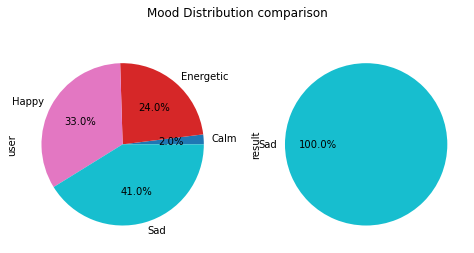

(401530, 54) (51, 54)
(1, 54)
Comparison of mood distribution with max genres of 50:


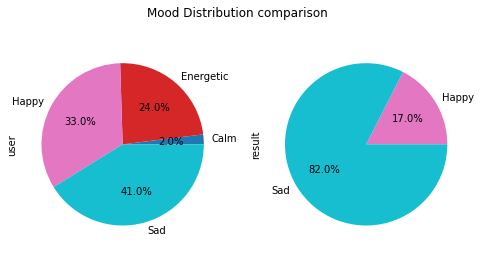

(401530, 204) (51, 204)
(1, 204)
Comparison of mood distribution with max genres of 200:


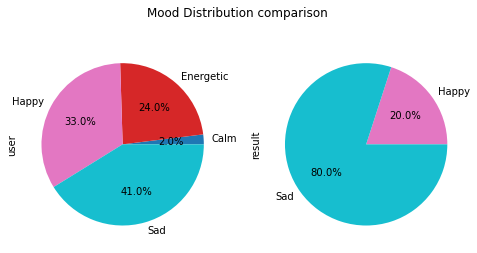

(401530, 1004) (51, 1004)
(1, 1004)
Comparison of mood distribution with max genres of 1000:


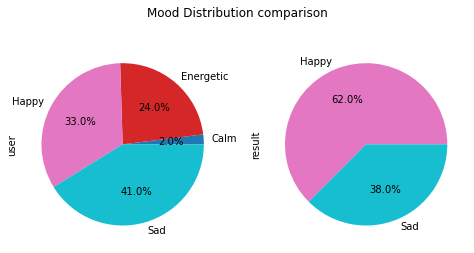

In [58]:
user_vectors = []
recommendations = []

for max_genres in max_genres_trials:
    (user_vector, results_df_sim) = make_recommendations(new_candidates_df,
                                                    new_user_top_tracks, max_genres)
    # Save the user vectors and recommendations
    user_vectors.append(user_vector)
    recommendations.append(results_df_sim)

If our theory were true, our new user should have a higher preference on `Sad`. We can confirm that is the case by printing the new user_vector.

In [59]:
user_vectors[0][0, :4], lb_user.classes_

(matrix([[ 2.71828183, 41.96093048, 55.55233962, 57.0839184 ]]),
 array(['Calm', 'Energetic', 'Happy', 'Sad'], dtype='<U9'))

Notice that this time the `Happy` tracks start to dominant as the features increase, which is still explainable with our theory.

But most importantly, did the system recommend any of the `new_candidates`?

In [60]:
new_candidates_tracks = new_candidates['track_name'].values

In [61]:
count = 0
for recommendation in recommendations:
    match_num = recommendation['track_name'].apply(lambda x: x in new_candidates_tracks).sum()
    if match_num != 0:
        count += match_num

print(f'Search finished, found {count} match case')

Search finished, found 0 match case


Our recommendation system failed to recommend any of the `new_candidates`. This is to be expected considering the following issues that we can infer from our current model:
- There are only four moods for our model to pick. This is not refined enough since there would still be a huge amount of tracks that belong to the mood that the user preferred.
- The recommendation is not balanced enough. It mostly only focuses on the very top mood our user had a preference on.
- To achieve a recommendation that fits our user's preference. We might have to apply some other recommendation methods such as collaborative filtering which is not achievable with our current method of acquiring data.
- The current evaluation method is not the best either. We cannot necessarily infer that the users would like a part of their favorite tracks since they liked the others. 

In the future, we will be keep working on resolving these issues and try to find a method that would make recommendations more evenly which might be achievable with clustering methods such as DBSCAN. We will also work on how to properly simulate Spotify users and the ground truth so we can properly evaluate and improve the recommender system.